In [1]:
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 526 (delta 143), reused 135 (delta 126), pack-reused 354
Receiving objects: 100% (526/526), 28.62 MiB | 23.07 MiB/s, done.
Resolving deltas: 100% (250/250), done.
/content/notebooks


In [2]:
from install import *
install_requirements(is_chapter6=True)

⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [3]:
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v2.0.0


In [4]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=f0ad30d127a1481105b91c0c6761c0de1e513d5b57ac0bd2610d0665420b880c
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [5]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
import wandb

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="NLP_With_HuggingFace")

wandb: Currently logged in as: abdussamad. Use `wandb login --relogin` to force relogin


In [7]:
from transformers import pipeline, set_seed

In [ ]:
#hide_output
from datasets import load_dataset
from datasets import list_datasets
list_of_datasets = list_datasets()
print(list_of_datasets)

In [9]:
len(list_of_datasets)

69037

We are summerizing text from CNN DailyMail dataset.
Three versions of dataset available on HuggingFace. Total 312000 samples available. 287000 samples for Training, 13400 samples for validation, and 11500 samples for test data.


1.   1.0.0
2.   2.0.0
3.   3.0.0

Dataset has 3 columns:
Articles: Long Text
Highlights: Summary of the article
ID: unique ID for sample

Size of the dataset is 1.76 GB.


In [10]:
dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [12]:
dataset['train'].column_names

['article', 'highlights', 'id']

In [13]:
sample = dataset['train'][1]
print(sample)

{'article': '(CNN) -- Usain Bolt rounded off the world championships Sunday by
claiming his third gold in Moscow as he anchored Jamaica to victory in the
men\'s 4x100m relay. The fastest man in the world charged clear of United States
rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole,
Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56
seconds with Canada taking the bronze after Britain were disqualified for a
faulty handover. The 26-year-old Bolt has now collected eight gold medals at
world championships, equaling the record held by American trio Carl Lewis,
Michael Johnson and Allyson Felix, not to mention the small matter of six
Olympic titles. The relay triumph followed individual successes in the 100 and
200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to
work to dominate for as long as possible," Bolt said, having previously
expressed his intention to carry on until the 2016 Rio Olympics. Victory 

In [14]:
sample['article'][:500]

"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n"

In [15]:
sample['highlights']

"Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay ."

In [16]:
len(sample['highlights'])

180

#Text Summarization Pipelines

In [17]:
sample_text = dataset['train'][1]['article'][:2000]

In [18]:
sample_text

'(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory was never se

In [19]:
# We will collect the summary in the dictionary
summaries = {}

The Natural Language Toolkit (NLTK) package includes a more sophisticated algorithm that can differentiate the end of a sentence from punctuation that occurs in abbreviations:

In [20]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
string = "The U.S. is new political alliance including Indian National Congress I.N.C. and U.N. and multiple other parties"
sent_tokenize(string)

['The U.S. is new political alliance including Indian National Congress I.N.C.',
 'and U.N. and multiple other parties']

#☝
[My Guess]Note: NLTK sent_tokenize does not understand the context. It has predefined set of abbreviations.

##Summarization Baseline


A common baseline for summarizing news articles is to simply take the first three
sentences of the article. With NLTK’s sentence tokenizer, we can easily implement
such a baseline:

In [22]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [23]:
summaries["baseline"] = three_sentence_summary(sample_text)

In [24]:
summaries['baseline']

"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover."

## Summerising with GPT2

In [25]:
from transformers import set_seed, pipeline

set_seed(42)
pipe = pipeline("text-generation",model='gpt2')

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [26]:
gpt2_query = sample_text + "\nTL;DR:\n"
gpt2_query

'(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory was never se

`clean_up_tokenization_spaces` (bool, optional, defaults to True) — Whether or not the model should cleanup the spaces that were added when splitting the input text during the tokenization process.

In [27]:
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)

In [28]:
pipe_out

[{'generated_text': '(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. 

In [29]:
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

In [30]:
summaries['gpt2']

"In the time it did take to get off to a good start Sunday in the women's 4x100m at Iredale Park, a Jamaican bronze medallist went to the line of his country and finished in 0.47 seconds, the fastest of the three Jamaica men.\nThe Jamaican player later announced on Twitter that he couldn't play for a second."

##T5
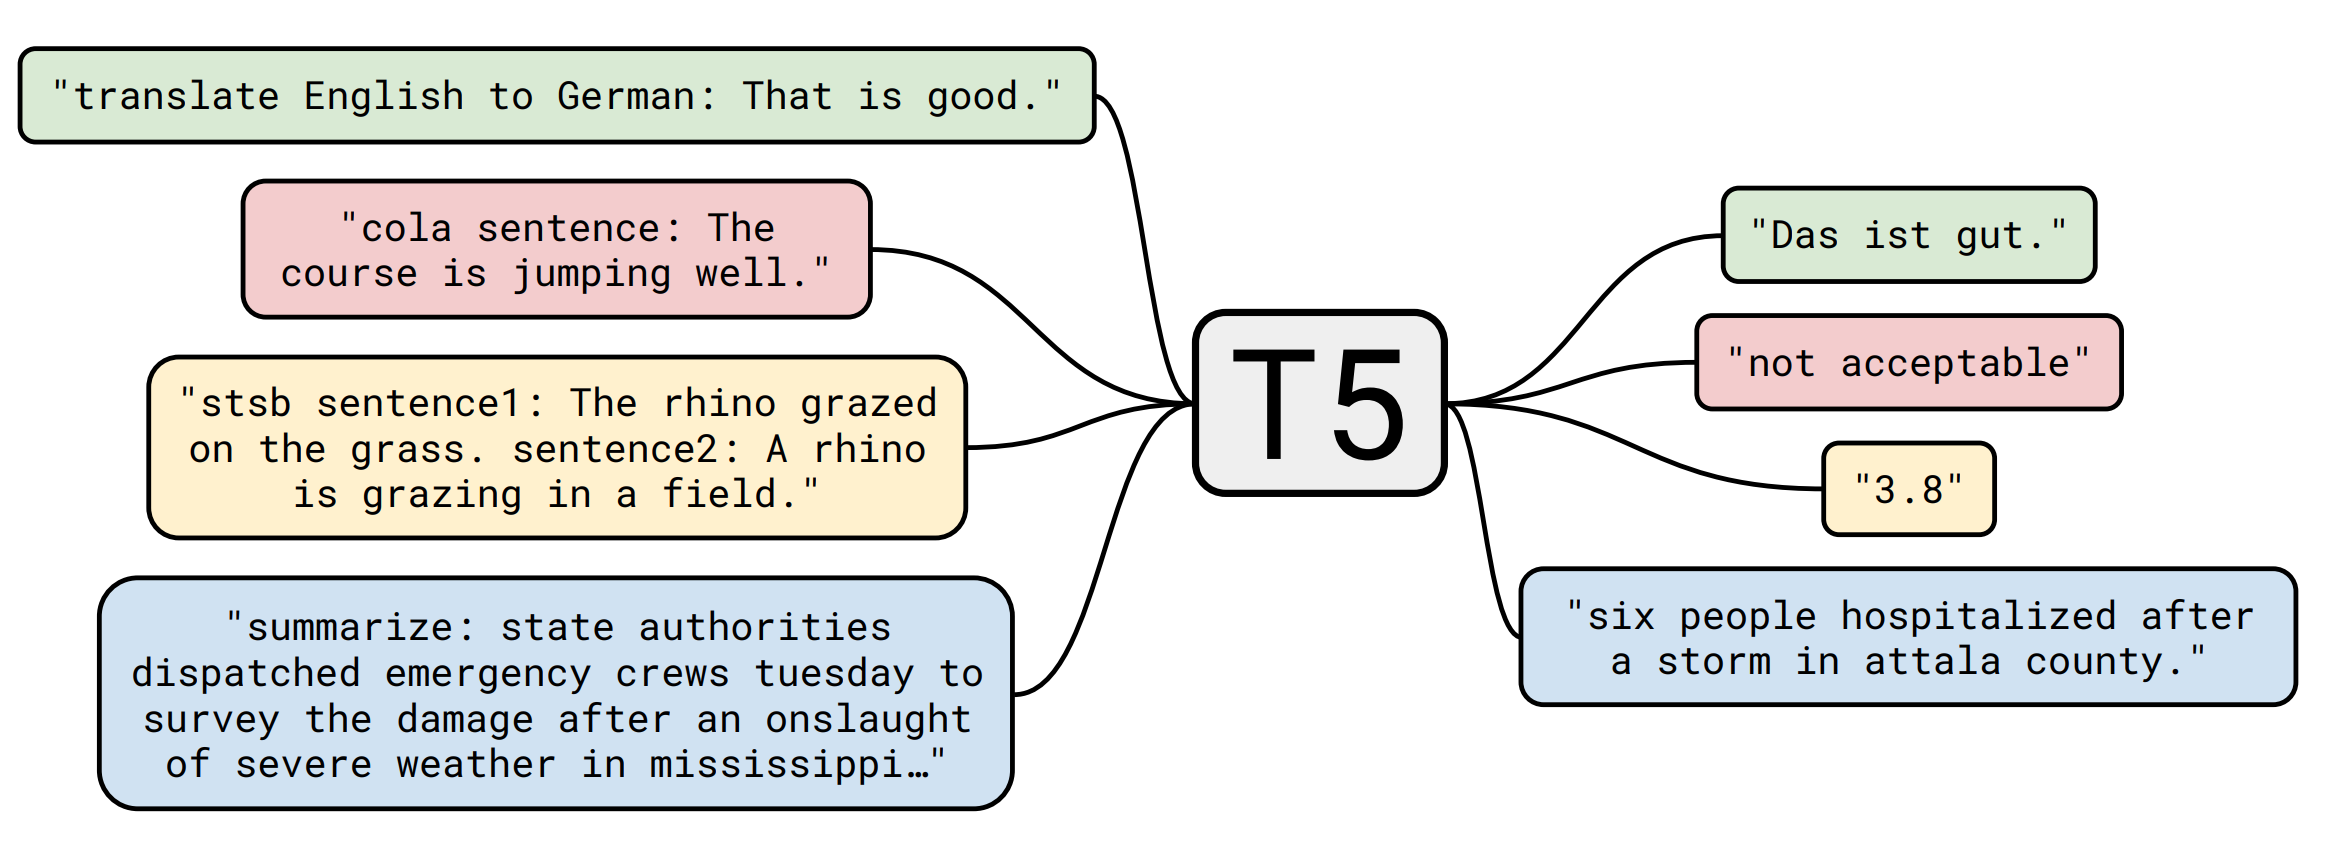

In [31]:
pipe = pipeline("text-generation",model='google/flan-t5-base')

Downloading:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/945M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['QDQBertLMHeadModel', 'TrOCRForCausalLM', 'GPTJForCausalLM', 'RemBertForCausalLM', 'RoFormerForCausalLM', 'BigBirdPegasusForCausalLM', 'GPTNeoForCausalLM', 'BigBirdForCausalLM', 'CamembertForCausalLM', 'XLMRobertaForCausalLM', 'RobertaForCausalLM', 'BertLMHeadModel', 'OpenAIGPTLMHeadModel', 'GPT2LMHeadModel', 'TransfoXLLMHeadModel', 'XLNetLMHeadModel', 'XLMWithLMHeadModel', 'ElectraForCausalLM', 'CTRLLMHeadModel', 'ReformerModelWithLMHead', 'BertGenerationDecoder', 'XLMProphetNetForCausalLM', 'ProphetNetForCausalLM', 'BartForCausalLM', 'MBartForCausalLM', 'PegasusForCausalLM', 'MarianForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'MegatronBertForCausalLM', 'Speech2Text2ForCausalLM'].


In [32]:
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"]))

In [33]:
summaries['t5']

'(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.\nThe 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles.\nThe relay triumph followed individual successes in the 100 and 200 meters in the Russian capital.\n"I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics.\nVictory was ne

##BART

In [34]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [35]:
summaries['bart']

"Usain Bolt wins his third gold of the world championships in Moscow.\nBolt anchors Jamaica to victory in the men's 4x100m relay.\nThe 26-year-old has now won eight gold medals at world championships.\nJamaica's women also win gold in the relay, beating France in the process."

#Comparative Analysis of multiple summarizations by different models:

In [36]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his
third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m
relay.
The fastest man in the world charged clear of United States rival Justin Gatlin
as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and
Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after
Britain were disqualified for a faulty handover.

GPT2
In the time it did take to get off to a good start Sunday in the women's 4x100m
at Iredale Park, a Jamaican bronze medallist went to the line of his country and
finished in 0.47 seconds, the fastest of the three Jamaica men.
The Jamaican player later announced on Twitter that he couldn't play for a
second.

T5
(CNN